In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
print(os.listdir("../input/data"))


['images_003', 'images_012', 'LOG_CHESTXRAY.pdf', 'README_CHESTXRAY.pdf', 'BBox_List_2017.csv', 'images_009', 'images_008', 'images_007', 'test_list.txt', 'images_010', 'ARXIV_V5_CHESTXRAY.pdf', 'images_002', 'images_011', 'Data_Entry_2017.csv', 'images_001', 'train_val_list.txt', 'images_005', 'FAQ_CHESTXRAY.pdf', 'images_004', 'images_006']


In [3]:
all_xray_df = pd.read_csv('../input/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('..', 'input/data', 'images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
#all_xray_df['Patient Age'] = all_xray_df['Patient Age'].map(lambda x: int(x[:-1]))
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
33327,00008741_002.png,No Finding,2,8741,32,F,AP,2048,2500,0.168,0.168,NaN,../input/data/images_004/images/00008741_002.png
89722,00022283_006.png,No Finding,6,22283,61,F,AP,3056,2544,0.139,0.139,NaN,../input/data/images_010/images/00022283_006.png
55357,00013876_004.png,Fibrosis,4,13876,48,M,PA,2992,2991,0.143,0.143,NaN,../input/data/images_007/images/00013876_004.png


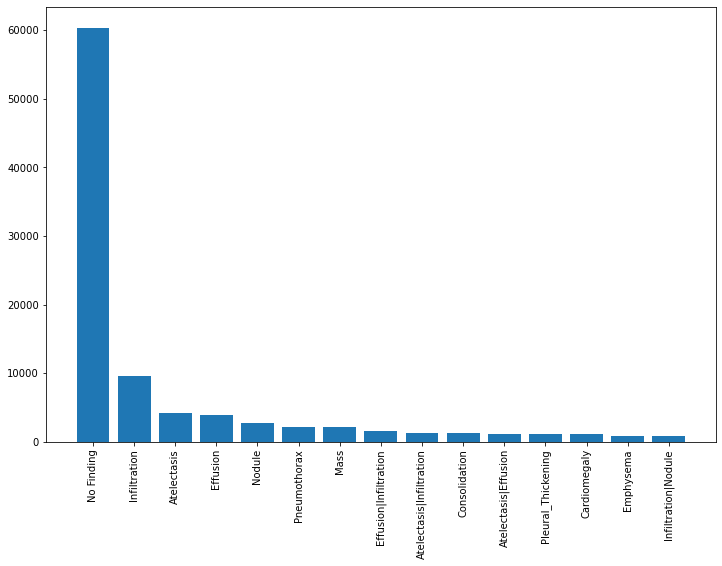

In [4]:
label_counts = all_xray_df['Finding Labels'].value_counts()[:15]
fig, ax1 = plt.subplots(1,1,figsize = (12, 8))
ax1.bar(np.arange(len(label_counts))+0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts))+0.5)
_ = ax1.set_xticklabels(label_counts.index, rotation = 90)

In [5]:
all_xray_df['Finding Labels'] = all_xray_df['Finding Labels'].map(lambda x: x.replace('No Finding', ''))
from itertools import chain
all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
all_xray_df.sample(3)

All Labels (14): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
56396,00014029_001.png,,1,14029,25,F,PA,2458,2747,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
106857,00028844_014.png,,14,28844,65,M,AP,3056,2544,0.139,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
38796,00010128_005.png,Emphysema,5,10128,67,M,PA,2992,2991,0.143,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
all_xray_df.shape


(112120, 27)

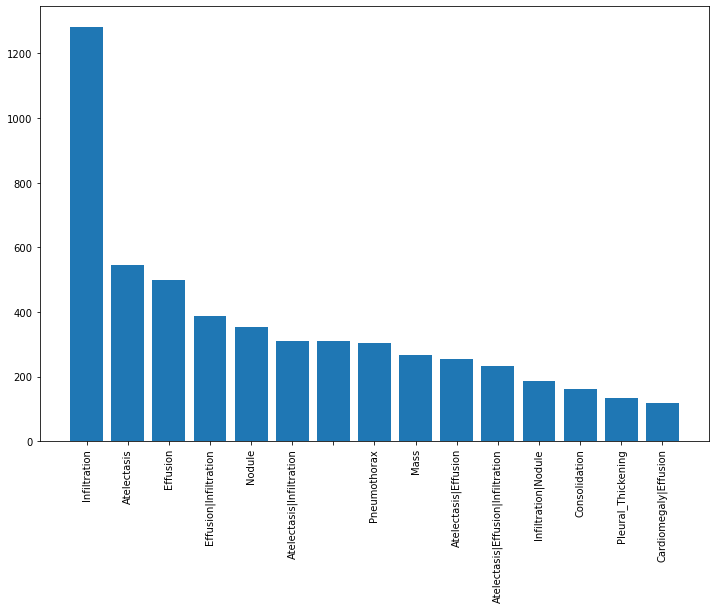

In [7]:
# since the dataset is very unbiased, we can resample it to be a more reasonable collection
# weight is 0.1 + number of findings
sample_weights = all_xray_df['Finding Labels'].map(lambda x: len(x.split('|')) if len(x)>0 else 0).values + 4e-2
sample_weights /= sample_weights.sum()
all_xray_df = all_xray_df.sample(10000, weights=sample_weights)

label_counts = all_xray_df['Finding Labels'].value_counts()[:15]
fig, ax1 = plt.subplots(1,1,figsize = (12, 8))
ax1.bar(np.arange(len(label_counts))+0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts))+0.5)
_ = ax1.set_xticklabels(label_counts.index, rotation = 90)

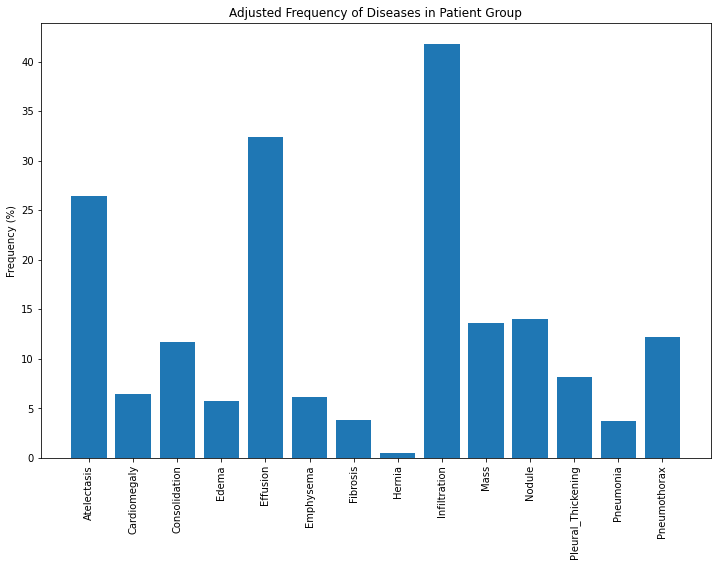

In [8]:
label_counts = 100*np.mean(all_xray_df[all_labels].values,0)
fig, ax1 = plt.subplots(1,1,figsize = (12, 8))
ax1.bar(np.arange(len(label_counts))+0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts))+0.5)
ax1.set_xticklabels(all_labels, rotation = 90)
ax1.set_title('Adjusted Frequency of Diseases in Patient Group')
_ = ax1.set_ylabel('Frequency (%)')

In [9]:
all_xray_df.shape


(10000, 27)

In [10]:
new_df = all_xray_df.sample(10000)


In [11]:
#We create a function, which reads an image, resizes it to 128 x128 dimensions and returns it.
import cv2
def read_img(img_path):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (128, 128))
    return img

from tqdm import tqdm 
train_img = []
for img_path in tqdm(new_df['path'].values):
    train_img.append(read_img( img_path))

100%|██████████| 10000/10000 [04:51<00:00, 34.36it/s]


In [12]:
X = np.array(train_img, np.float32) / 255 


In [13]:
Y = new_df[all_labels].values


In [14]:
from sklearn.model_selection import train_test_split
X_train,X_test, Y_train,Y_test = train_test_split(X, Y ,
                                   test_size = 0.25, 
                                   random_state = 2018)
print('train', X_train.shape[0], 'validation', X_test.shape[0])

train 7500 validation 2500


In [15]:
del X
del Y

In [16]:
X_train.shape


(7500, 128, 128, 3)

In [17]:
Y_train.shape


(7500, 14)

In [18]:
from keras.applications.mobilenet import MobileNet
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from keras.models import Sequential
base_mobilenet_model = MobileNet(input_shape =  (128,128,3), 
                                 include_top = False, weights = None)
multi_disease_model = Sequential()
multi_disease_model.add(base_mobilenet_model)
multi_disease_model.add(GlobalAveragePooling2D())
multi_disease_model.add(Dropout(0.5))
multi_disease_model.add(Dense(512))
multi_disease_model.add(Dropout(0.5))
multi_disease_model.add(Dense(len(all_labels), activation = 'sigmoid'))
multi_disease_model.compile(optimizer = 'adam', loss = 'binary_crossentropy',
                           metrics = ['binary_accuracy', 'mae'])
multi_disease_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_128 (Function (None, 4, 4, 1024)        3228864   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               524800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 14)                7182      
Total params: 3,760,846
Trainable params: 3,738,958
Non-trainable params: 21,888
_________________________________________

In [19]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=3)
callbacks_list = [checkpoint, early]

First Round
Here we do a first round of training to get a few initial low hanging fruit results

In [20]:
#We define an early stopping condition for the model. If the val_acc is the same three times, the model stops.

early_stops = EarlyStopping(patience=3, monitor='val_acc')
#Training the model for 10 epochs.

multi_disease_model.fit(x=X_train, y=Y_train, batch_size=100, epochs=5, validation_split=0.3, callbacks=[early_stops])

Epoch 1/5
53/53 [==============================] - 9s 165ms/step - loss: 0.4523 - binary_accuracy: 0.8379 - mae: 0.2117 - val_loss: 0.4242 - val_binary_accuracy: 0.8633 - val_mae: 0.3209
Epoch 2/5
53/53 [==============================] - 8s 144ms/step - loss: 0.3752 - binary_accuracy: 0.8594 - mae: 0.2055 - val_loss: 0.3495 - val_binary_accuracy: 0.8633 - val_mae: 0.2081
Epoch 3/5
53/53 [==============================] - 8s 146ms/step - loss: 0.3561 - binary_accuracy: 0.8623 - mae: 0.2053 - val_loss: 0.3638 - val_binary_accuracy: 0.8633 - val_mae: 0.1790
Epoch 4/5
53/53 [==============================] - 8s 148ms/step - loss: 0.3448 - binary_accuracy: 0.8646 - mae: 0.2026 - val_loss: 0.3912 - val_binary_accuracy: 0.8633 - val_mae: 0.1682
Epoch 5/5
53/53 [==============================] - 8s 145ms/step - loss: 0.3401 - binary_accuracy: 0.8654 - mae: 0.2003 - val_loss: 0.4130 - val_binary_accuracy: 0.8633 - val_mae: 0.1596


In [21]:
for c_label, s_count in zip(all_labels, 100*np.mean(Y_test,0)):
    print('%s: %2.2f%%' % (c_label, s_count))

Atelectasis: 25.96%
Cardiomegaly: 6.32%
Consolidation: 11.36%
Edema: 5.12%
Effusion: 32.68%
Emphysema: 6.88%
Fibrosis: 3.48%
Hernia: 0.68%
Infiltration: 40.88%
Mass: 13.88%
Nodule: 14.28%
Pleural_Thickening: 8.56%
Pneumonia: 4.16%
Pneumothorax: 12.44%


In [22]:
pred_Y = multi_disease_model.predict(X_test, batch_size = 32, verbose = True)

79/79 [==============================] - 1s 11ms/step


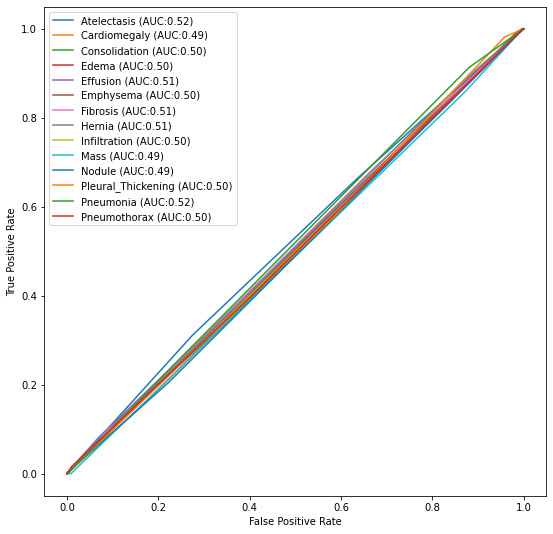

In [23]:
from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, c_label) in enumerate(all_labels):
    fpr, tpr, thresholds = roc_curve(Y_test[:,idx].astype(int), pred_Y[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig('barely_trained_net.png')

In [24]:
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score, average_precision_score
print('ROC auc score: {:.3f}'.format(roc_auc_score(Y_test.astype(int), pred_Y)))

ROC auc score: 0.503


In [25]:
#We define an early stopping condition for the model. If the val_acc is the same three times, the model stops.

early_stops = EarlyStopping(patience=3, monitor='val_acc')
#Training the model for 10 epochs.

multi_disease_model.fit(x=X_train, y=Y_train, batch_size=100, epochs=50, validation_split=0.3, callbacks=[early_stops])

Epoch 1/50
53/53 [==============================] - 8s 160ms/step - loss: 0.3354 - binary_accuracy: 0.8671 - mae: 0.1993 - val_loss: 0.4282 - val_binary_accuracy: 0.8633 - val_mae: 0.1601
Epoch 2/50
53/53 [==============================] - 8s 149ms/step - loss: 0.3296 - binary_accuracy: 0.8694 - mae: 0.1964 - val_loss: 0.4363 - val_binary_accuracy: 0.8633 - val_mae: 0.1569
Epoch 3/50
53/53 [==============================] - 8s 147ms/step - loss: 0.3256 - binary_accuracy: 0.8707 - mae: 0.1951 - val_loss: 0.4582 - val_binary_accuracy: 0.8633 - val_mae: 0.1549
Epoch 4/50
53/53 [==============================] - 8s 148ms/step - loss: 0.3230 - binary_accuracy: 0.8716 - mae: 0.1929 - val_loss: 0.4493 - val_binary_accuracy: 0.8633 - val_mae: 0.1604
Epoch 5/50
53/53 [==============================] - 8s 149ms/step - loss: 0.3195 - binary_accuracy: 0.8723 - mae: 0.1918 - val_loss: 0.4493 - val_binary_accuracy: 0.8633 - val_mae: 0.1571
Epoch 6/50
53/53 [==============================] - 8s 146ms

53/53 [==============================] - 8s 145ms/step - loss: 0.0639 - binary_accuracy: 0.9762 - mae: 0.0355 - val_loss: 0.7863 - val_binary_accuracy: 0.7917 - val_mae: 0.2209
Epoch 45/50
53/53 [==============================] - 8s 147ms/step - loss: 0.0640 - binary_accuracy: 0.9760 - mae: 0.0353 - val_loss: 0.7168 - val_binary_accuracy: 0.7912 - val_mae: 0.2273
Epoch 46/50
53/53 [==============================] - 8s 148ms/step - loss: 0.0651 - binary_accuracy: 0.9762 - mae: 0.0367 - val_loss: 0.7277 - val_binary_accuracy: 0.7919 - val_mae: 0.2283
Epoch 47/50
53/53 [==============================] - 8s 154ms/step - loss: 0.0563 - binary_accuracy: 0.9795 - mae: 0.0312 - val_loss: 0.7916 - val_binary_accuracy: 0.8120 - val_mae: 0.1999
Epoch 48/50
53/53 [==============================] - 8s 145ms/step - loss: 0.0548 - binary_accuracy: 0.9800 - mae: 0.0308 - val_loss: 0.9391 - val_binary_accuracy: 0.8093 - val_mae: 0.1970
Epoch 49/50
53/53 [==============================] - 8s 144ms/step 

In [26]:
for c_label, s_count in zip(all_labels, 100*np.mean(Y_test,0)):
    print('%s: %2.2f%%' % (c_label, s_count)) 

Atelectasis: 25.96%
Cardiomegaly: 6.32%
Consolidation: 11.36%
Edema: 5.12%
Effusion: 32.68%
Emphysema: 6.88%
Fibrosis: 3.48%
Hernia: 0.68%
Infiltration: 40.88%
Mass: 13.88%
Nodule: 14.28%
Pleural_Thickening: 8.56%
Pneumonia: 4.16%
Pneumothorax: 12.44%


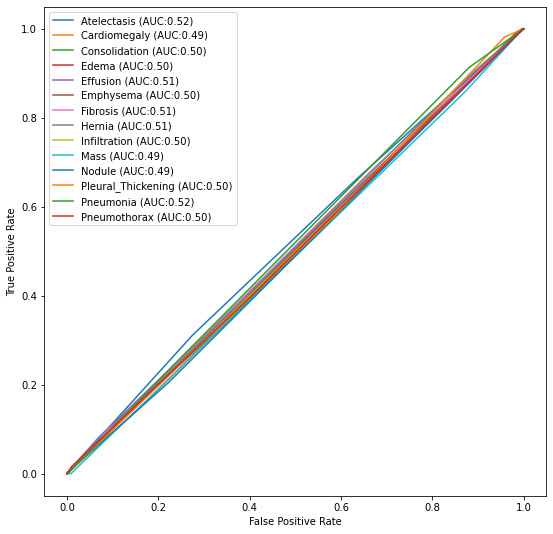

In [27]:
from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, c_label) in enumerate(all_labels):
    fpr, tpr, thresholds = roc_curve(Y_test[:,idx].astype(int), pred_Y[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig('barely_trained_net.png')

In [28]:
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score, average_precision_score
print('ROC auc score: {:.3f}'.format(roc_auc_score(Y_test.astype(int), pred_Y)))

ROC auc score: 0.503


In [29]:
history=multi_disease_model.fit(x=X_train, y=Y_train, batch_size=100, epochs=10, validation_split=0.3, callbacks=[early_stops])

Epoch 1/10
53/53 [==============================] - 8s 152ms/step - loss: 0.0495 - binary_accuracy: 0.9823 - mae: 0.0273 - val_loss: 0.8116 - val_binary_accuracy: 0.8013 - val_mae: 0.2097
Epoch 2/10
53/53 [==============================] - 8s 143ms/step - loss: 0.0495 - binary_accuracy: 0.9819 - mae: 0.0271 - val_loss: 0.7871 - val_binary_accuracy: 0.8003 - val_mae: 0.2114
Epoch 3/10
53/53 [==============================] - 8s 145ms/step - loss: 0.0510 - binary_accuracy: 0.9818 - mae: 0.0277 - val_loss: 0.8179 - val_binary_accuracy: 0.8210 - val_mae: 0.1877
Epoch 4/10
53/53 [==============================] - 8s 146ms/step - loss: 0.0486 - binary_accuracy: 0.9823 - mae: 0.0264 - val_loss: 0.8080 - val_binary_accuracy: 0.7968 - val_mae: 0.2143
Epoch 5/10
53/53 [==============================] - 8s 146ms/step - loss: 0.0455 - binary_accuracy: 0.9833 - mae: 0.0253 - val_loss: 0.8336 - val_binary_accuracy: 0.8071 - val_mae: 0.2022
Epoch 6/10
53/53 [==============================] - 8s 145ms

In [30]:
for c_label, s_count in zip(all_labels, 100*np.mean(Y_test,0)):
    print('%s: %2.2f%%' % (c_label, s_count)) 

Atelectasis: 25.96%
Cardiomegaly: 6.32%
Consolidation: 11.36%
Edema: 5.12%
Effusion: 32.68%
Emphysema: 6.88%
Fibrosis: 3.48%
Hernia: 0.68%
Infiltration: 40.88%
Mass: 13.88%
Nodule: 14.28%
Pleural_Thickening: 8.56%
Pneumonia: 4.16%
Pneumothorax: 12.44%


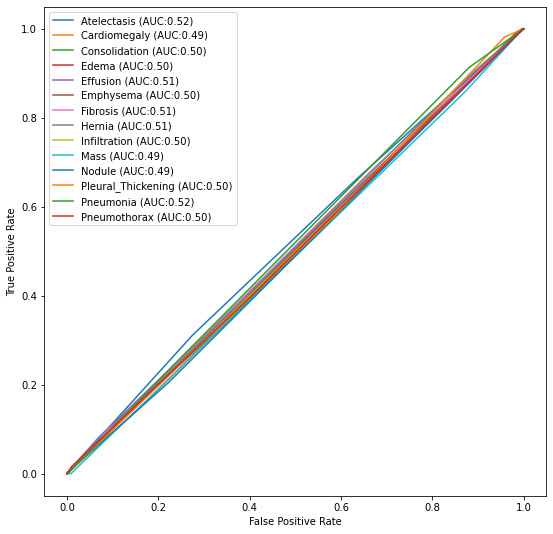

In [31]:
from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, c_label) in enumerate(all_labels):
    fpr, tpr, thresholds = roc_curve(Y_test[:,idx].astype(int), pred_Y[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig('barely_trained_net.png')

In [32]:
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score, average_precision_score
print('ROC auc score: {:.3f}'.format(roc_auc_score(Y_test.astype(int), pred_Y)))

ROC auc score: 0.503


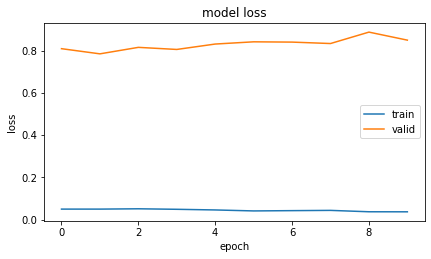

In [33]:
plt.figure(1, figsize = (15,8)) 
    
plt.subplot(222)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 

plt.show()